This project aims to test FaceNet system for face recognition. FaceNet is proposed by [Florian Schroff](http://www.florian-schroff.de) in the 2015 paper [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)

A pretrained FaceNet model by [Hiroki Taniai](https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn) is used here.

This project is inspired by [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/)

Import libraries

In [2]:
import numpy as np 
import pandas as pd
import cv2 
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from tensorflow.python.keras.models import load_model
from PIL import Image
import os

['dataset', '4318_6669_bundle_archive.zip', 'face-recognition-with-facenet.ipynb', '.ipynb_checkpoints']


See a sample image

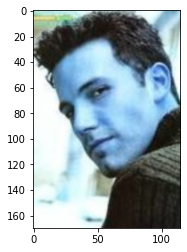

(170, 115, 3)


In [3]:
img = cv2.imread('./5-celebrity-faces-dataset/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

The extract_face function load a image file and return the extracted face in 160 * 160 pixels shape as needed for trained FaceNet model

Try the extract_face() on the sample image. Works nicely

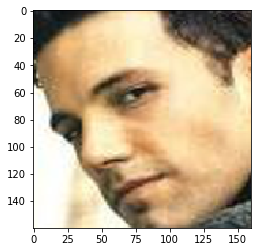

(160, 160, 3)


In [5]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('./5-celebrity-faces-dataset/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

Apply extract_face() for all faces in the dataset

In [6]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('./5-celebrity-faces-dataset/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('./5-celebrity-faces-dataset/data/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)
        

loaded 21 sample for class: jerry_seinfeld


loaded 17 sample for class: elton_john


loaded 14 sample for class: ben_afflek


loaded 19 sample for class: madonna


loaded 22 sample for class: mindy_kaling
(93, 160, 160, 3) (93,)


loaded 5 sample for class: jerry_seinfeld


loaded 5 sample for class: elton_john


loaded 5 sample for class: ben_afflek


loaded 5 sample for class: madonna


loaded 5 sample for class: mindy_kaling
(25, 160, 160, 3) (25,)


In [7]:
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [7]:
# load the facenet model
facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded Model


Next step is standardizing the faces and extracting a embedding vector using the model

In [8]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(93, 128)
(25, 128)


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Randomly select a face from test set for prediction. Calculate confidence

Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[ 4.04160464  7.28549548 83.60998201  2.33587968  2.72703819]
Expected: jerry_seinfeld


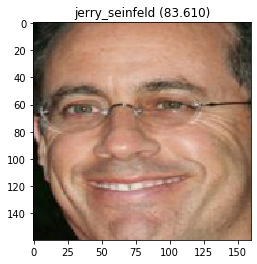

In [24]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
